# Gradient boosted forest model

## Assessing the predictive ability of a gradient boosted forest model
Using a training and testing split of the DCD and DBD datasets to fit and assess the predictive ability of a gradient boosted model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as mets
%matplotlib inline

In [3]:
#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in paper
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]
     
#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_apps[dbd_cols].astype(int)

dbd_model_data = dbd_apps[dbd_cols]
dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"]

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_apps[dbd_cols].astype(int)

dcd_model_data = dcd_apps[dcd_cols]
dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"]

# creating a train and testing dataset for DBD and DCD approaches

# 1382 consents, 618 non-consents in test data
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)

# 1865 consents, 1239 non-consents in t
DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [4]:
# fitting tree to training data 
boost_model = GradientBoostingClassifier()

In [11]:
DBD_boost = boost_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_boost.predict(DBD_X_test)

cm = mets.confusion_matrix(DBD_y_test, DBD_preds)

print("TN  FN\nFP  TP\n")
print(str(int(cm[0,0])) + "    " + str(int(cm[0,1])))
print(str(int(cm[1,0])) + "    " + str(int(cm[1,1])) + "\n") 

# classification report for DBD model
print(mets.classification_report(DBD_y_test, DBD_preds))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DBD_y_test, DBD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DBD_y_test, DBD_preds),2)))

TN  FN
FP  TP

234    384
104    1278

              precision    recall  f1-score   support

         1.0       0.69      0.38      0.49       618
         2.0       0.77      0.92      0.84      1382

    accuracy                           0.76      2000
   macro avg       0.73      0.65      0.66      2000
weighted avg       0.75      0.76      0.73      2000

Balanced accuracy: 0.65
Accuracy: 0.76


In [7]:
DCD_boost = boost_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_boost.predict(DCD_X_test)

dcd_cm = mets.confusion_matrix(DCD_y_test, DCD_preds)

print("TN  FN\nFP  TP\n")
print(str(int(dcd_cm[0,0])) + "    " + str(int(dcd_cm[0,1])))
print(str(int(dcd_cm[1,0])) + "    " + str(int(dcd_cm[1,1])) + "\n") 

# classification report for DCD model
print(mets.classification_report(DCD_y_test, DCD_preds))

print("Cohen kappa: " + str(round(mets.cohen_kappa_score(DCD_y_test, DCD_preds),2)))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DCD_y_test, DCD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DCD_y_test, DCD_preds),2)))

TN  FN
FP  TP

790    449
388    1477

              precision    recall  f1-score   support

         1.0       0.67      0.64      0.65      1239
         2.0       0.77      0.79      0.78      1865

    accuracy                           0.73      3104
   macro avg       0.72      0.71      0.72      3104
weighted avg       0.73      0.73      0.73      3104

Cohen kappa: 0.43
Balanced accuracy: 0.71
Accuracy: 0.73


## Hyperparameter tuning

In [29]:
# loop through learning rates and fit boosted tress and output the metrics
learning_rates = np.arange(start=0.1, stop=100, step=2)
recall_cons = []
recall_refs = []
bas = []

for rate in learning_rates:
    boosted_model = GradientBoostingClassifier(learning_rate=rate)
    DBD_tree = boosted_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_tree.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))  

Text(0.5, 0, 'Learning rate')

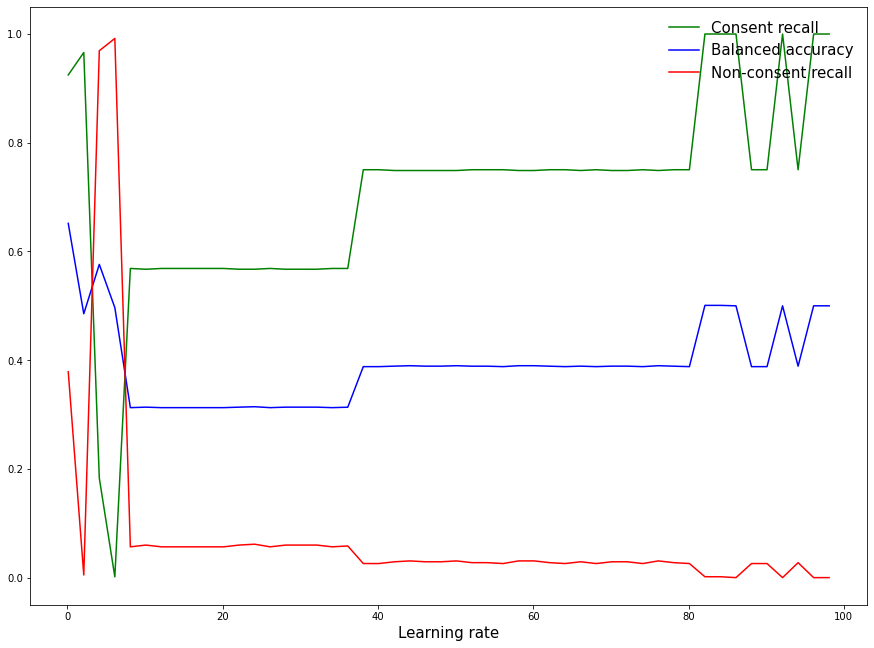

In [30]:
# plot recall for each class and balanced accuracy against learning rate
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(learning_rates,recall_cons, 'g-')
ax.plot(learning_rates,bas,'b-')
ax.plot(learning_rates,recall_refs,'r-')

ax.legend(["Consent recall","Balanced accuracy", "Non-consent recall"],loc=1,fontsize=15,frameon=False)

plt.xlabel("Learning rate", fontsize=15)